In [1]:
import pytest
pytest.importorskip('pycuda')

<module 'pycuda' from '/home/markus/miniconda3/envs/pystencils/lib/python3.8/site-packages/pycuda/__init__.py'>

In [2]:
from lbmpy.session import *
from lbmpy.phasefield.scenarios import create_n_phase_model
from pystencils.datahandling import SerialDataHandling
from lbmpy.phasefield.analytical import *
from lbmpy.phasefield.experiments1D import *
from lbmpy.phasefield.analytical import analytic_interface_profile
from functools import partial

## Tanh test

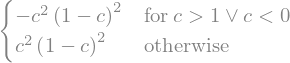

In [3]:
width = 100
f2 = partial(n_phases_correction_function_sign_switch, beta=1)


sc1 = create_n_phase_model(data_handling=SerialDataHandling((width, 1), 
                                                            periodicity=True),
                           f2=f2,
                           num_phases=4, alpha=1)

phaseIdx = 1
init_sharp_interface(sc1, phase_idx=1, inverse=False)
#init_sharp_interface(sc1, phase_idx=0, inverse=True)

sc1.set_pdf_fields_from_macroscopic_values()

f2(sp.Symbol("c"))

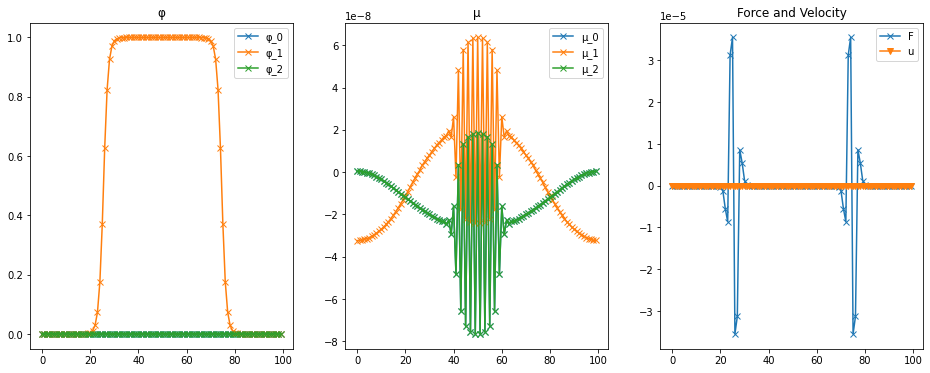

In [4]:
if 'is_test_run' in globals():
    sc1.run(1000)
else:
    sc1.run(100_000)
plot_status(sc1)
sc1.time_steps_run

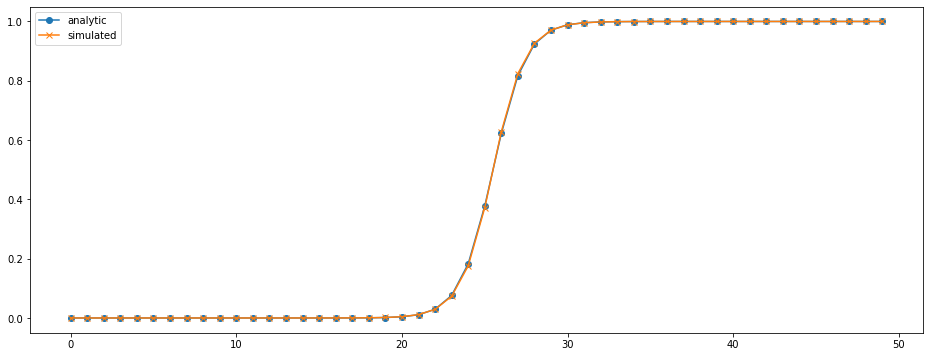

In [5]:
alpha = 1
visWidth = 25
x = np.arange(2 * visWidth) - visWidth
analytic = np.array([analytic_interface_profile(x_i - 0.5, alpha) for x_i in x], dtype=np.float64)

visSlice = make_slice[25 - visWidth:25 + visWidth, 0, phaseIdx]
simulated = sc1.phi_slice(visSlice).copy()

plt.plot(analytic, label='analytic', marker='o')
plt.plot(simulated, label='simulated', marker='x')
plt.legend();

In [6]:
assert not np.isnan(np.max(simulated))

# Phase separation

In [7]:
num_phases = 3
f2 = partial(n_phases_correction_function, power=2, beta=0.001)
ll = create_n_phase_model(data_handling=SerialDataHandling((200, 200), 
                                                            periodicity=True),
                          f2=f2,
                          surface_tensions=lambda i, j: 0.0025/2 if i != j else 0,
                          num_phases=num_phases, alpha=1,
                          cahn_hilliard_relaxation_rates=1.2,
                          optimization={'target': 'gpu'})

In [8]:
ll.set_concentration(make_slice[:, :], [1/num_phases] * (ll.num_order_parameters + 1))
φ_arr = ll.data_handling.cpu_arrays['pf_phi']
φ_arr += (np.random.rand(*φ_arr.shape)-0.5) * 0.2
ll.set_pdf_fields_from_macroscopic_values()
#plt.phase_plot_for_step(ll)

In [9]:
f_bulk, f_if = separate_into_bulk_and_interface(ll.free_energy)
φ = sp.symbols("phi_:{}".format(num_phases))
hessian = sp.hessian(f_bulk, φ)

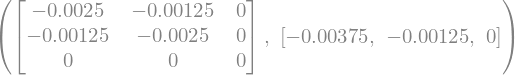

In [10]:
evaluated_hessian = hessian.subs({ f: 1/num_phases for f in φ})
eigenvalues = [a.evalf()  for a,b in evaluated_hessian.eigenvals().items()]
assert any(a < 0 for a in eigenvalues)
evaluated_hessian, eigenvalues

In [11]:
eigenvalues

In [12]:
if 'is_test_run' in globals():
    ll.run(1000)
else:
    for i in range(24):
        ll.run(2_000)
        min_φ, max_φ = np.min(ll.phi[:, :]), np.max(ll.phi[:, :])
        print(i, min_φ, max_φ)
        if max_φ > 0.6:
            break
    assert max_φ > 0.6
    ll.time_steps_run

0 0.2758155929237753 0.38473570562133785
1 0.2748161360080074 0.38488772564114726
2 0.2683532586237162 0.3871572718138226
3 0.2600168631368765 0.39061504733864205
4 0.2497121108406234 0.3950213454293126
5 0.23711762210158974 0.4025594738800712
6 0.22193262882621828 0.41193625447766674
7 0.20407321268090212 0.4225758522668233
8 0.18336056861272843 0.4345515516610015
9 0.16101259243931312 0.44790599932582714
10 0.138093763434249 0.4626354952613849
11 0.11557498219160023 0.4786414072946536
12 0.09582005109374259 0.4956281231789832
13 0.07897339964491129 0.5129436925263354
14 0.06589580852638396 0.5299402490277405
15 0.0565689594874494 0.5484308468125921
16 0.049859780240342856 0.565000435447876
17 0.044883159520440793 0.5813998562607967
18 0.04001044347236109 0.5977276606277677
19 0.034983328318103295 0.6166442216104449


In [13]:
ll.run(4_000)
np.min(ll.phi[:, :]), np.max(ll.phi[:, :])

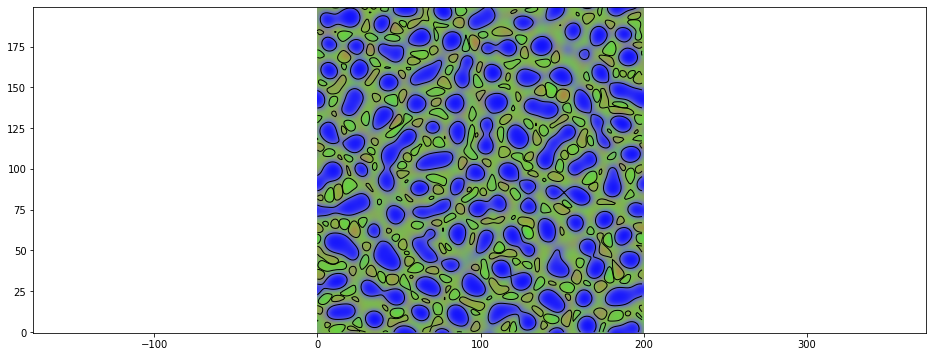

In [14]:
if 'is_test_run' not in globals():
    plt.phase_plot_for_step(ll)

## 2) Advection Test

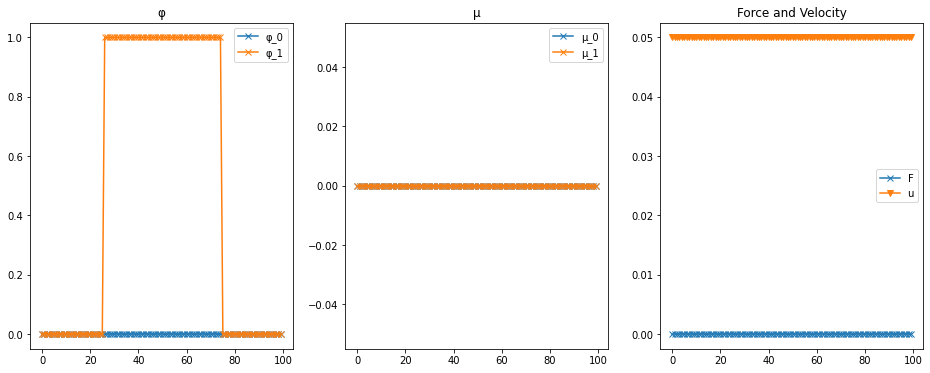

In [15]:
sc2 = create_n_phase_model(data_handling=SerialDataHandling((width, 1), periodicity=True),
                           num_phases=3, alpha=alpha)

ux = 0.05
phase_idx =1 
sc2.data_handling.fill(sc2.vel_field_name, ux, value_idx=0)
init_sharp_interface(sc2, phase_idx=phase_idx, inverse=False)

sc2.set_pdf_fields_from_macroscopic_values()
plot_status(sc2)

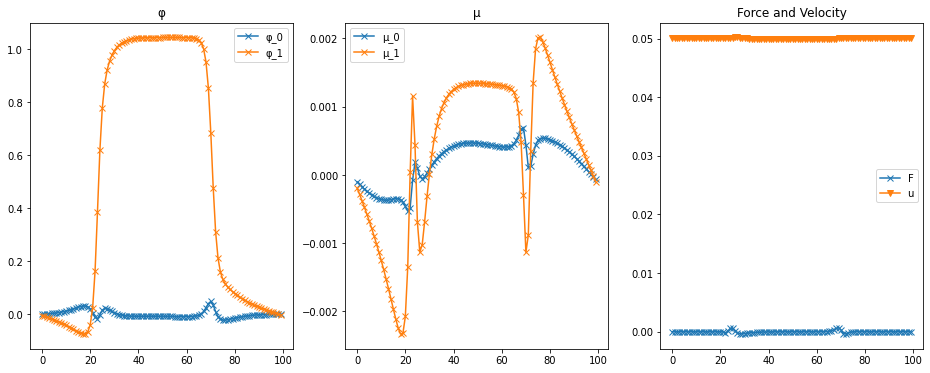

In [16]:
if 'is_test_run' in globals():
    sc2.run(1000)
else:
    sc2.run(10_000)
    assert abs(np.average(sc2.velocity[:, :, 0]) - 0.05) < 1e-10
plot_status(sc2)